In [2]:
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

## Data loader

In [3]:
dataset: DatasetDict = load_dataset("sonlam1102/vihsd")

train = pd.DataFrame(dataset['train'])

dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 24048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

In [6]:
# Load augmented eda data
aug_eda_offensive = pd.read_csv('data/aug_eda_offensive.csv', sep='|')
aug_eda_hate = pd.read_csv('data/aug_eda_hate.csv', sep='|')

# Add to train in dataset
eda_dataset = DatasetDict(dataset)
eda_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_eda_offensive, aug_eda_hate], ignore_index=True)
)
eda_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34290
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

In [7]:
# Load augmented llm data
aug_llm_offensive = pd.read_csv('data/aug_llm_offensive.csv', sep='|')
aug_llm_hate = pd.read_csv('data/aug_llm_hate.csv', sep='|')

# Add to train in dataset
llm_dataset = DatasetDict(dataset)
llm_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_llm_offensive, aug_llm_hate], ignore_index=True)
)
llm_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

## Preprocessing

In [3]:
EMOTICON_PATH = 'data/convert/emoticon.txt'
TEENCODE_PATH = 'data/convert/teencode.txt'

In [4]:
# Technique 1: Standardizing words
def remove_character(text: str) -> str:
    """Standardize text by removing consecutive characters."""
    return re.sub(r'(.)\1+', r'\1', text)


# Technique 2: Converting emoticons to emojis
emoticon_df = pd.read_csv(EMOTICON_PATH, sep='|', header=None)
emoticon_data = dict(zip(emoticon_df[0], emoticon_df[1]))

def convert_emoticon(text: str) -> str:
    """Convert emoticon to emoji."""
    for k, v in emoticon_data.items():
        text = re.sub(re.escape(k), f' {v} ', text)
    return text


# Technique 3: Convert teencode to complete word
teencode_df = pd.read_csv(TEENCODE_PATH, sep='|', header=None)
teencode_data = dict(zip(teencode_df[0], teencode_df[1]))

def convert_teencode(text: str) -> str:
    """Convert teencode to complete word."""
    for k, v in teencode_data.items():
        text = re.sub(rf'\b{re.escape(k)}\b', f' {v} ', text)
    return text


# Normalize text
emoji_pattern = (
    r'['
    '\U0001f600-\U0001f64f'
    '\U0001f300-\U0001f5ff'
    '\U0001f680-\U0001f6ff'
    '\U0001f1e0-\U0001f1ff'
    '\U00002600-\U000026ff'
    '\U00002700-\U000027bf'
    ']+'
)
tokenize_pattern = re.compile(r'\w+|' + emoji_pattern + r'|[^\s\w]+')


def normalize_text(text: str) -> str:
    """Normalize text with consistent spacing between tokens."""
    return ' '.join(tokenize_pattern.findall(text))

In [13]:
preprocess_methods = {
    '1': remove_character,
    '2': convert_emoticon,
    '3': convert_teencode,
}

def preprocess_text(text: str, methods: list[str], normalize: bool = False) -> str:
    text = str(text)

    for method in methods:
        text = preprocess_methods[method](text)

    if normalize:
        text = normalize_text(text)

    return text

## Model

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, ignore_index=-100) -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        logits = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logits)
        logits = (1 - pt) ** self.gamma * logits
        loss = F.nll_loss(logits, targets, weight=self.weight, ignore_index=self.ignore_index)
        return loss

    # def forward(self, inputs, targets):
    #     ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, ignore_index=self.ignore_index)
    #     pt = torch.exp(-ce_loss)
    #     loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
    #     return loss


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = FocalLoss()(logits, labels)
        return (loss, outputs) if return_outputs else loss


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, preprocess_methods=[], normalize=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.preprocess_methods = preprocess_methods
        self.normalize = normalize

        self.load_encodings()

    def load_encodings(self):
        self.encodings = []
        for text in self.texts:
            text = preprocess_text(text, self.preprocess_methods, self.normalize)
            encoding = self.tokenizer(
                text, padding='max_length', truncation=True, max_length=self.max_length
            )
            self.encodings.append(encoding)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels[idx]

        return {
            'input_ids': torch.tensor(encoding['input_ids']),
            'attention_mask': torch.tensor(encoding['attention_mask']),
            'labels': torch.tensor(label),
        }

In [15]:
def train(
    dataset: DatasetDict,
    model_name: str,
    max_length: int = 128,
    batch_size: int = 16,
    num_epochs: int = 3,
    learning_rate: float = 2e-5,
    preprocess_methods: list[str] = [],
    normalize: bool = False,
    output_dir: str | None = None,
    device: str = 'cpu',
) -> Trainer:
    if output_dir is None:
        output_dir = f'./results/{time.strftime("%Y%m%d_%H%M%S")}'

    labels = ['CLEAN', 'OFFENSIVE', 'HATE']

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

    def get_ds(split: str) -> CustomDataset:
        df = pd.DataFrame(dataset[split])
        return CustomDataset(
            df['free_text'],
            df['label_id'],
            tokenizer,
            max_length,
            preprocess_methods,
            normalize,
        )

    train_ds = get_ds('train')
    dev_ds = get_ds('validation')
    test_ds = get_ds('test')

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        warmup_steps=100,
        weight_decay=0.01,
        do_eval=True,
        no_cuda=device == 'cpu',
        logging_steps=200,
        report_to=[],
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=dev_ds,
    )

    trainer.train()
    trainer.save_model(output_dir)

    y_pred_classify = trainer.predict(test_ds)

    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    y_true = test_ds.labels

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    f1_micro = f1_score(y_true, y_pred, average='micro')
    print(f'F1 - micro: {f1_micro}')

    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f'F1 - macro: {f1_macro}')

    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)

    # Visualize confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True') 
    plt.tight_layout()
    plt.show()

    return trainer

## ViSoBERT - No Preprocessing - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.179300
400,0.118300
600,0.070700
800,0.060500
1000,0.023100
1200,0.021200
1400,0.010900
1600,0.008800
1800,0.004900


[[5301  116  131]
 [ 185  189   70]
 [ 191   70  427]]
F1 - micro: 0.8857784431137724
F1 - macro: 0.6849911727218272
              precision    recall  f1-score   support

       CLEAN       0.93      0.96      0.94      5548
   OFFENSIVE       0.50      0.43      0.46       444
        HATE       0.68      0.62      0.65       688

    accuracy                           0.89      6680
   macro avg       0.71      0.67      0.68      6680
weighted avg       0.88      0.89      0.88      6680



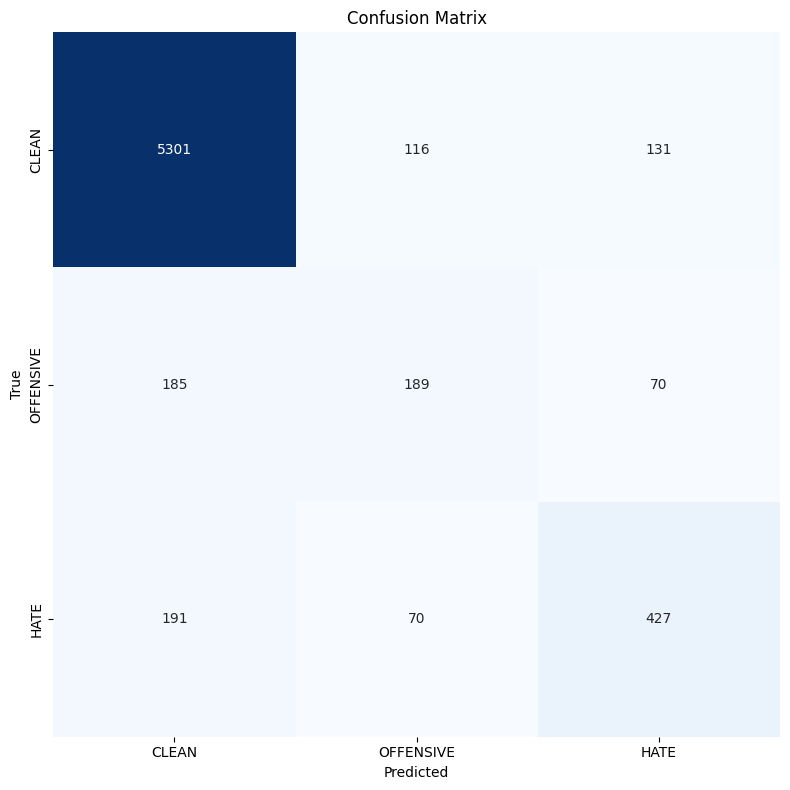

In [17]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=[],
    normalize=False,
    output_dir='./results/visobert/no_pp-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## ViSoBERT - Normalize - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.172300
400,0.119800
600,0.072300
800,0.062800
1000,0.024700
1200,0.022300
1400,0.011000
1600,0.008400
1800,0.005500


[[5295  113  140]
 [ 174  205   65]
 [ 190   71  427]]
F1 - micro: 0.8872754491017965
F1 - macro: 0.6947038997682241
              precision    recall  f1-score   support

       CLEAN       0.94      0.95      0.94      5548
   OFFENSIVE       0.53      0.46      0.49       444
        HATE       0.68      0.62      0.65       688

    accuracy                           0.89      6680
   macro avg       0.71      0.68      0.69      6680
weighted avg       0.88      0.89      0.88      6680



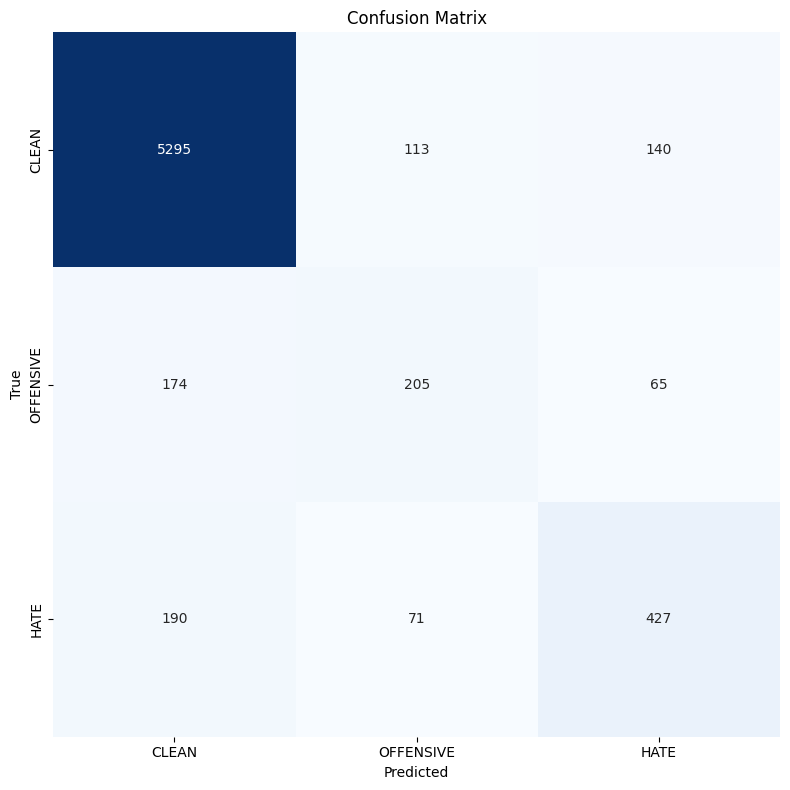

In [18]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=[],
    normalize=True,
    output_dir='./results/visobert/norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## ViSoBERT - 1 + Normalize - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.174200
400,0.120800
600,0.073100
800,0.062500
1000,0.025300
1200,0.022600
1400,0.011400
1600,0.008800
1800,0.005800


[[5306  113  129]
 [ 176  195   73]
 [ 196   76  416]]
F1 - micro: 0.8857784431137724
F1 - macro: 0.6844599192706163
              precision    recall  f1-score   support

       CLEAN       0.93      0.96      0.95      5548
   OFFENSIVE       0.51      0.44      0.47       444
        HATE       0.67      0.60      0.64       688

    accuracy                           0.89      6680
   macro avg       0.71      0.67      0.68      6680
weighted avg       0.88      0.89      0.88      6680



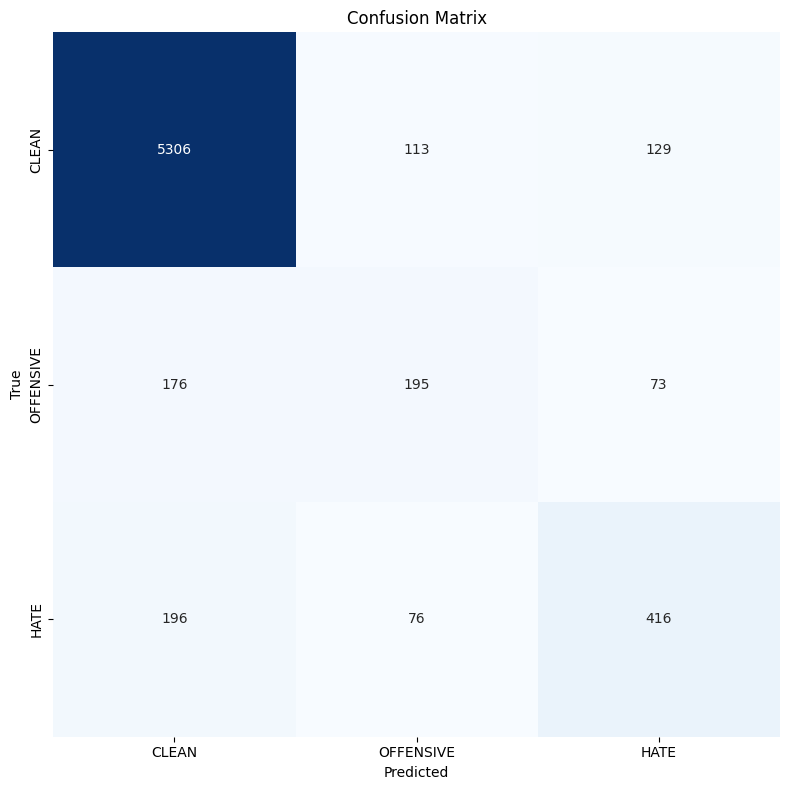

In [19]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1'],
    normalize=True,
    output_dir='./results/visobert/1-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## ViSoBERT - 1 + 2 + Normalize - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.184500
400,0.121000
600,0.073700
800,0.062400
1000,0.024700
1200,0.023000
1400,0.011600
1600,0.009800
1800,0.005300


[[5278  125  145]
 [ 173  206   65]
 [ 189   73  426]]
F1 - micro: 0.8847305389221557
F1 - macro: 0.6909548309554691
              precision    recall  f1-score   support

       CLEAN       0.94      0.95      0.94      5548
   OFFENSIVE       0.51      0.46      0.49       444
        HATE       0.67      0.62      0.64       688

    accuracy                           0.88      6680
   macro avg       0.71      0.68      0.69      6680
weighted avg       0.88      0.88      0.88      6680



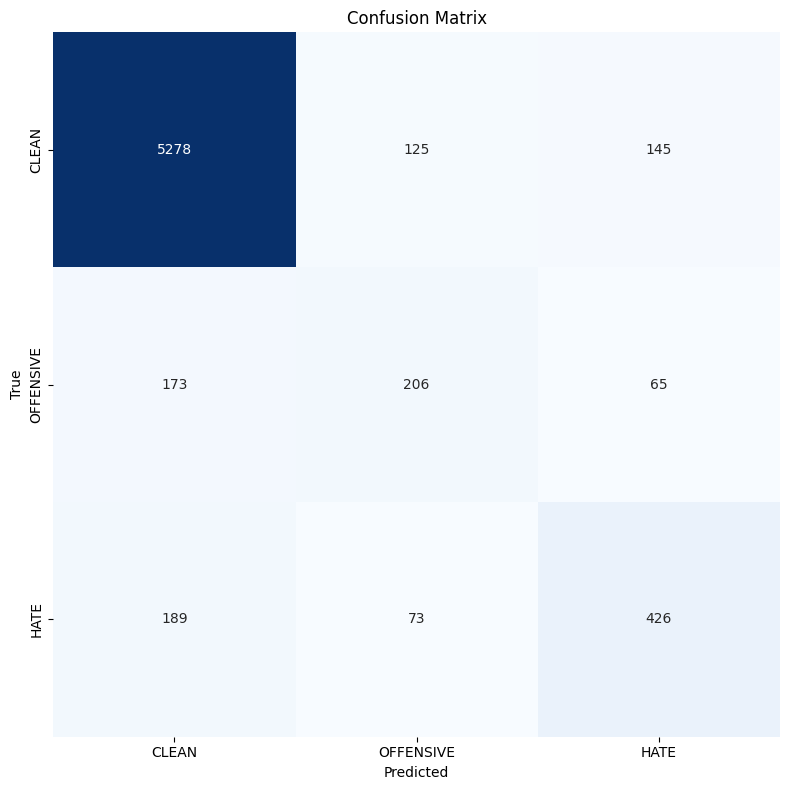

In [17]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2'],
    normalize=True,
    output_dir='./results/visobert/1-2-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## ViSoBERT - 1 + 3 + Normalize - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.186500
400,0.122900
600,0.074100
800,0.063400
1000,0.025500
1200,0.024000
1400,0.011200
1600,0.009700
1800,0.005200


[[5300  113  135]
 [ 181  199   64]
 [ 197   77  414]]
F1 - micro: 0.8851796407185629
F1 - macro: 0.6861537409170265
              precision    recall  f1-score   support

       CLEAN       0.93      0.96      0.94      5548
   OFFENSIVE       0.51      0.45      0.48       444
        HATE       0.68      0.60      0.64       688

    accuracy                           0.89      6680
   macro avg       0.71      0.67      0.69      6680
weighted avg       0.88      0.89      0.88      6680



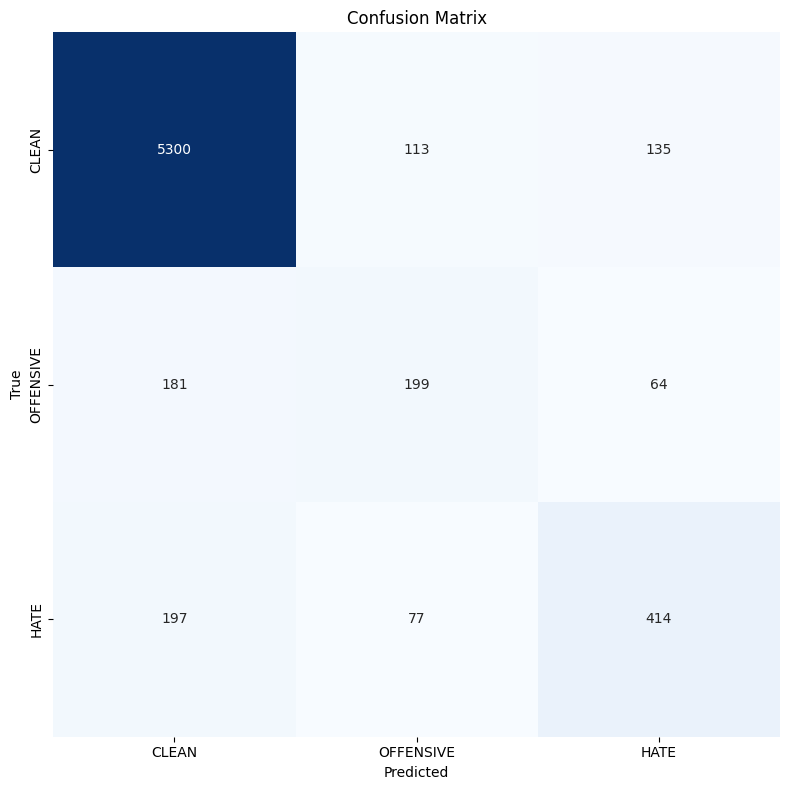

In [18]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '3'],
    normalize=True,
    output_dir='./results/visobert/1-3-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## VisoBERT - 1 + 2 + 3 + Normalize - No Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.175800
400,0.122800
600,0.073400
800,0.062900
1000,0.025300
1200,0.023100
1400,0.011400
1600,0.008700
1800,0.005700


[[5307  117  124]
 [ 184  193   67]
 [ 206   68  414]]
F1 - micro: 0.8853293413173653
F1 - macro: 0.684614592008692
              precision    recall  f1-score   support

       CLEAN       0.93      0.96      0.94      5548
   OFFENSIVE       0.51      0.43      0.47       444
        HATE       0.68      0.60      0.64       688

    accuracy                           0.89      6680
   macro avg       0.71      0.66      0.68      6680
weighted avg       0.88      0.89      0.88      6680



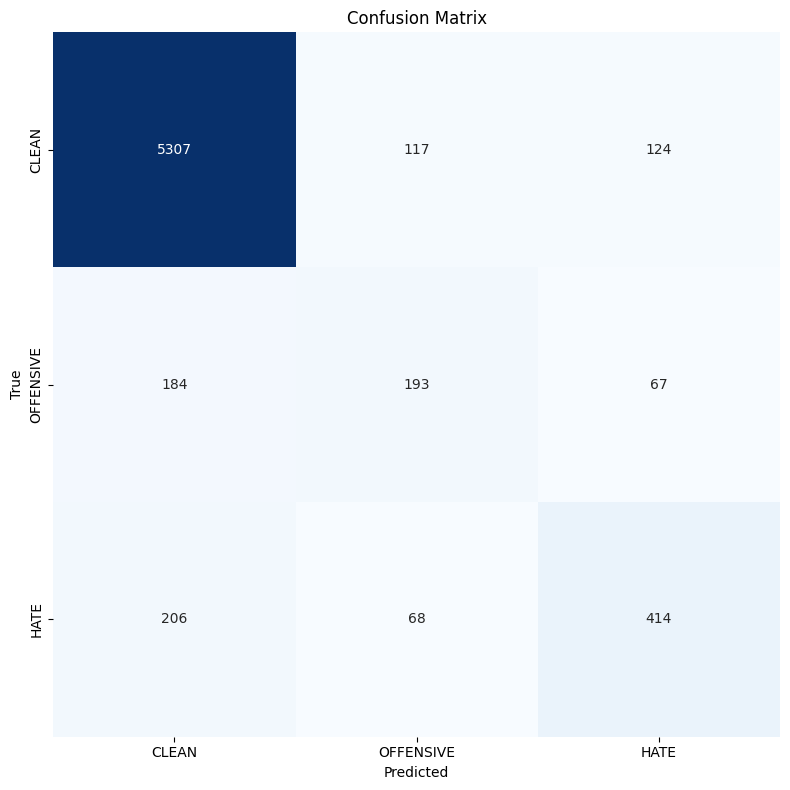

In [18]:
train(
    dataset=dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/visobert/1-2-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## VisoBERT - 1 + 2 + 3 + Normalize - EDA Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.229500
400,0.146400
600,0.097900
800,0.051800
1000,0.045900
1200,0.025200
1400,0.016700
1600,0.016500
1800,0.008400
2000,0.007400


[[5290  113  145]
 [ 206  161   77]
 [ 231   35  422]]
F1 - micro: 0.8791916167664671
F1 - macro: 0.6665385591243136
              precision    recall  f1-score   support

       CLEAN       0.92      0.95      0.94      5548
   OFFENSIVE       0.52      0.36      0.43       444
        HATE       0.66      0.61      0.63       688

    accuracy                           0.88      6680
   macro avg       0.70      0.64      0.67      6680
weighted avg       0.87      0.88      0.87      6680



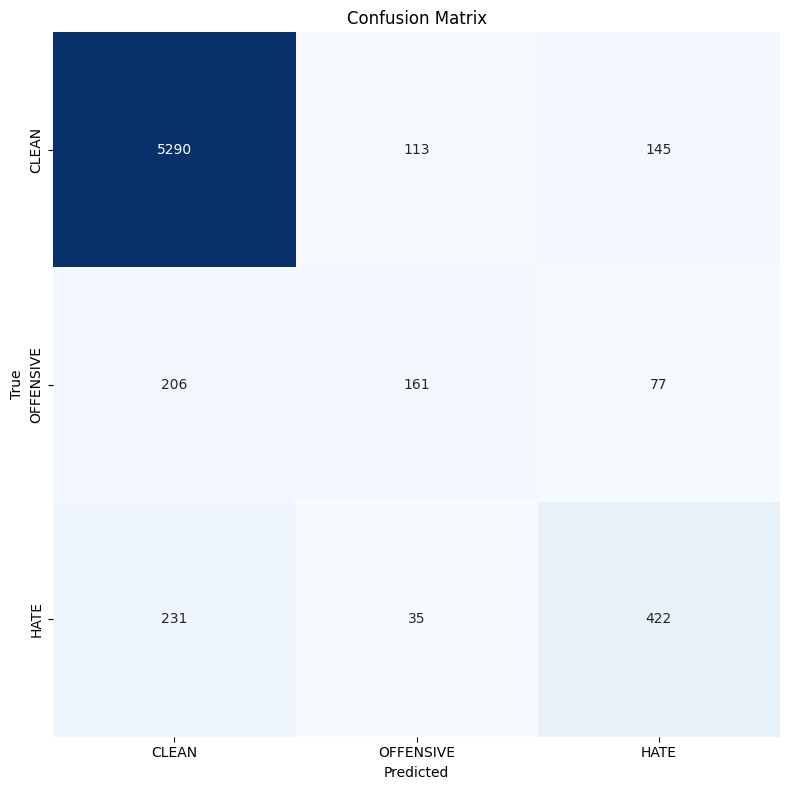

In [20]:
train(
    dataset=eda_dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/visobert/1-2-3-norm-eda_data',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## VisoBERT - 1 + 2 + 3 + Normalize - LLM Augmented Data

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.185500
400,0.123300
600,0.097700
800,0.066700
1000,0.066600
1200,0.040500
1400,0.029000
1600,0.025600
1800,0.012600
2000,0.013200


[[5299  115  134]
 [ 171  207   66]
 [ 208   80  400]]
F1 - micro: 0.8841317365269461
F1 - macro: 0.6848460501080386
              precision    recall  f1-score   support

       CLEAN       0.93      0.96      0.94      5548
   OFFENSIVE       0.51      0.47      0.49       444
        HATE       0.67      0.58      0.62       688

    accuracy                           0.88      6680
   macro avg       0.70      0.67      0.68      6680
weighted avg       0.88      0.88      0.88      6680



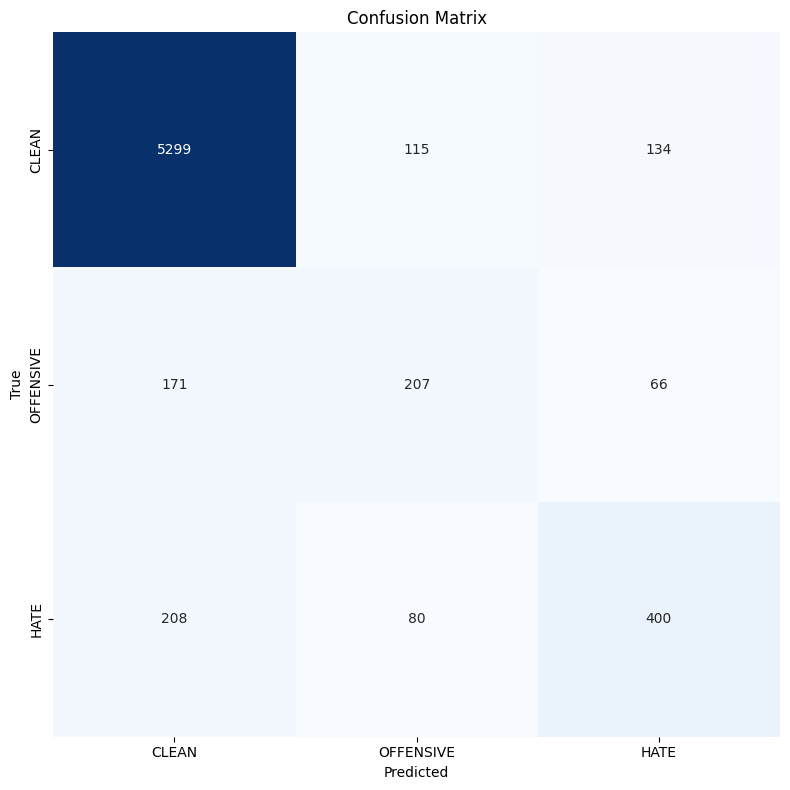

In [21]:
train(
    dataset=llm_dataset,
    model_name='uitnlp/visobert',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/phobert/1-2-3-norm-llm_data',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)